In [1]:
# Importation des librairies
import os
import pandas as pd
import spacy
nlp = spacy.load('fr_core_news_md')

from preprocessing import PreProcesseur
import matplotlib.pyplot as plt


pd.options.display.max_columns = None

In [29]:
# Lecture des données feel

path_feel = "/home/erwan/Centrale/OSY/Projet_OSY/sentiment-analysis/data/Feel-fr/FEEL.txt"
if not os.path.exists(path_feel):
    raise FileNotFoundError("file {} doesn't exist".format(path_feel))
    
feel = pd.read_csv(path_feel, sep=";", header=None)
feel.columns = ['id', 'sentence', 'valence', 'rien', 'fear', 'sadness', 'anger', 'surprise', 'disgust', 'joy']
feel = feel.drop(['id', 'valence'], axis=1)


#### A REMPLACER, on travaille actuellement uniquement sur les premières lignes pour tester
#feel = feel[:500]

In [30]:
X = ['fear', 'sadness', 'anger', 'surprise', 'disgust', 'joy']
feel.head()

,sentence,rien,fear,sadness,anger,surprise,disgust,joy
0,à ce endroit là,0,0,0,0,0,0,0
1,à le hâte,0,1,0,0,1,0,0
2,à part,0,0,1,0,0,0,0
3,à pic,0,1,0,0,0,0,0
4,à rallonge,0,0,1,0,0,0,0


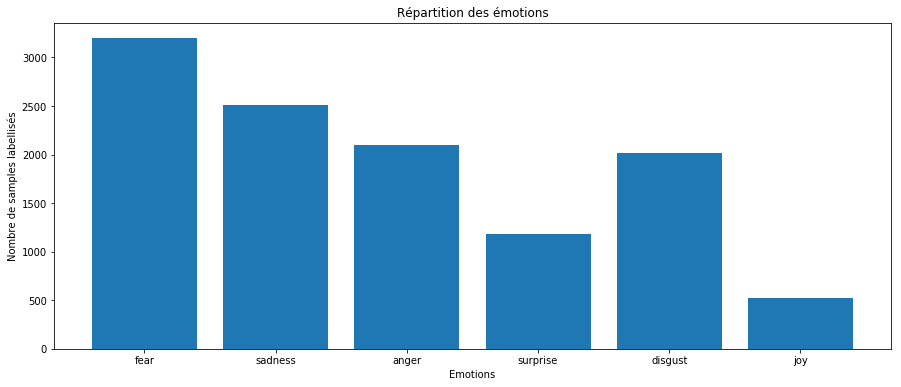

In [31]:
# Affichage des émotions du dataset
plt.figure(figsize=(15, 6))
Y = [feel.loc[feel[sentiment] == 1].count()[0] for sentiment in X]
plt.bar(X, Y)
plt.title('Répartition des émotions')
plt.xlabel('Emotions')
plt.ylabel('Nombre de samples labellisés')
plt.show()

In [32]:
# Duplication des lignes qui possèdent plusieurs sentiments
def process_label(dataset):    
    new_dataset = pd.DataFrame(columns=['sentence', 'emotion'])
    
    for i in range(dataset.shape[0]):
        has_emotion = False
        for sentiment in X:
            if dataset.iloc[i][sentiment] == 1:
                has_emotion = True
                new_dataset = new_dataset.append({'sentence': dataset.iloc[i]['sentence'],
                                                  'emotion': sentiment
                                                 }, ignore_index=True)
        if not has_emotion:
            new_dataset = new_dataset.append({'sentence': dataset.iloc[i]['sentence'], 
                                              'emotion': 'no_emotion'
                                             }, ignore_index=True)
    
    return new_dataset
    
feel = process_label(feel)
print('new shape : {}'.format(feel.shape))
feel.head()

new shape : (19444, 2)


,sentence,emotion
0,à ce endroit là,no_emotion
1,à le hâte,fear
2,à le hâte,surprise
3,à part,sadness
4,à pic,fear


In [34]:
# Traitement NLP du dataset (tokenisation, normalisation ?? lemmatization ??)
# La méthode rapide utilise spacy, on sait moins ce que l'on utilise par contre...
fast = False

if fast:
    feel['nlp_sentence'] = feel['sentence'].map(lambda sentence: nlp(sentence))
else:
    preprocessor = PreProcesseur()
    feel['nlp_sentence'] = feel['sentence'].map(lambda sentence: preprocessor.process_all(sentence, type='stem', verbose=False))
    feel.head()

In [35]:
feel.head()

,sentence,emotion,nlp_sentence
0,à ce endroit là,no_emotion,"[a, endroit]"
1,à le hâte,fear,"[a, hat]"
2,à le hâte,surprise,"[a, hat]"
3,à part,sadness,"[a, part]"
4,à pic,fear,"[a, pic]"


In [41]:
#feel['nlp_sentence'] = feel['nlp_sentence'].map(lambda el: " ".join(el))

y_train = feel.emotion
x_train = feel.nlp_sentence

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(CountVectorizer(), TfidfTransformer())

pipe.fit(x_train)
feat_train = pipe.transform(x_train)

from sklearn.ensemble import RandomForestClassifier

RandFor = RandomForestClassifier(n_estimators=100, n_jobs=-1)
RandFor.fit(feat_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

,sentence,emotion,nlp_sentence
0,à ce endroit là,no_emotion,a endroit
1,à le hâte,fear,a hat
2,à le hâte,surprise,a hat
3,à part,sadness,a part
4,à pic,fear,a pic


In [8]:
# Vectorisation de chaque phrase
# TODO : on peut essayer d'utiliser fast-text gensim ou notre propre words embedding.

# a choisir entre tf-idf et w2v
type_vector = 'w2c'

if type_vector == 'w2c':
    feel['vector'] = feel.nlp_sentence.map(lambda token : token.vector)
elif type_vector == 'tf-idf':
    from sklearn.feature_extraction.text import TfidfVectorizer

    vectorizer = TfidfVectorizer()
    feel['vector'] = vectorizer.fit_transform(feel['sentence'])

feel.head()

AttributeError: 'list' object has no attribute 'vector'

In [15]:
# Split des vecteurs
data = feel[['emotion', 'vector']]

dim = len(data.vector.iloc[0])
for i in range(dim):
    data['vec_{}'.format(i)] = data.vector.map(lambda vec: vec[i])

# suppression de la colonne vector
data = data.drop(['vector'], axis=1)

data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,emotion,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,vec_10,vec_11,vec_12,vec_13,vec_14,vec_15,vec_16,vec_17,vec_18,vec_19,vec_20,vec_21,vec_22,vec_23,vec_24,vec_25,vec_26,vec_27,vec_28,vec_29,vec_30,vec_31,vec_32,vec_33,vec_34,vec_35,vec_36,vec_37,vec_38,vec_39,vec_40,vec_41,vec_42,vec_43,vec_44,vec_45,vec_46,vec_47,vec_48,vec_49,vec_50,vec_51,vec_52,vec_53,vec_54,vec_55,vec_56,vec_57,vec_58,vec_59,vec_60,vec_61,vec_62,vec_63,vec_64,vec_65,vec_66,vec_67,vec_68,vec_69,vec_70,vec_71,vec_72,vec_73,vec_74,vec_75,vec_76,vec_77,vec_78,vec_79,vec_80,vec_81,vec_82,vec_83,vec_84,vec_85,vec_86,vec_87,vec_88,vec_89,vec_90,vec_91,vec_92,vec_93,vec_94,vec_95,vec_96,vec_97,vec_98,vec_99,vec_100,vec_101,vec_102,vec_103,vec_104,vec_105,vec_106,vec_107,vec_108,vec_109,vec_110,vec_111,vec_112,vec_113,vec_114,vec_115,vec_116,vec_117,vec_118,vec_119,vec_120,vec_121,vec_122,vec_123,vec_124,vec_125,vec_126,vec_127,vec_128,vec_129,vec_130,vec_131,vec_132,vec_133,vec_134,vec_135,vec_136,vec_137,vec_138,vec_139,vec_140,vec_141,vec_142,vec_143,vec_144,vec_145,vec_146,vec_147,vec_148,vec_149,vec_150,vec_151,vec_152,vec_153,vec_154,vec_155,vec_156,vec_157,vec_158,vec_159,vec_160,vec_161,vec_162,vec_163,vec_164,vec_165,vec_166,vec_167,vec_168,vec_169,vec_170,vec_171,vec_172,vec_173,vec_174,vec_175,vec_176,vec_177,vec_178,vec_179,vec_180,vec_181,vec_182,vec_183,vec_184,vec_185,vec_186,vec_187,vec_188,vec_189,vec_190,vec_191,vec_192,vec_193,vec_194,vec_195,vec_196,vec_197,vec_198,vec_199,vec_200,vec_201,vec_202,vec_203,vec_204,vec_205,vec_206,vec_207,vec_208,vec_209,vec_210,vec_211,vec_212,vec_213,vec_214,vec_215,vec_216,vec_217,vec_218,vec_219,vec_220,vec_221,vec_222,vec_223,vec_224,vec_225,vec_226,vec_227,vec_228,vec_229,vec_230,vec_231,vec_232,vec_233,vec_234,vec_235,vec_236,vec_237,vec_238,vec_239,vec_240,vec_241,vec_242,vec_243,vec_244,vec_245,vec_246,vec_247,vec_248,vec_249,vec_250,vec_251,vec_252,vec_253,vec_254,vec_255,vec_256,vec_257,vec_258,vec_259,vec_260,vec_261,vec_262,vec_263,vec_264,vec_265,vec_266,vec_267,vec_268,vec_269,vec_270,vec_271,vec_272,vec_273,vec_274,vec_275,vec_276,vec_277,vec_278,vec_279,vec_280,vec_281,vec_282,vec_283,vec_284,vec_285,vec_286,vec_287,vec_288,vec_289,vec_290,vec_291,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299
0,0,0.057724,1.071546,-0.499995,-1.722287,0.161467,-1.009474,-0.297377,-0.124410,0.061092,-0.316292,0.827832,0.050325,-0.708436,-1.141509,1.381718,0.417665,1.270278,-0.486028,0.717480,-0.404188,-0.978868,0.252411,-0.262432,0.648712,0.447122,-0.941638,-1.217129,-1.203740,-0.000635,0.268641,-0.165685,0.285208,-0.824620,0.220064,-1.188607,-0.104033,0.181995,0.397961,0.516886,-0.096218,-0.246694,-1.433110,0.502068,0.071777,0.246539,0.655809,-0.612083,0.199657,-0.391332,0.071688,0.352279,0.691475,-0.089573,-0.701259,-0.447501,-0.103209,1.026017,-0.178961,-1.015273,0.367667,0.144758,-0.821156,-0.589543,0.039251,0.422213,0.464808,-0.055311,-0.395709,0.508797,-0.744380,0.355495,-0.054597,0.539396,0.078110,-0.505373,-0.081889,-0.144732,0.020310,-0.425172,-0.452385,1.409310,-0.866911,0.310323,-0.346273,-0.110703,-1.158743,-0.107384,0.578983,-0.073651,-0.127522,-0.247924,0.470464,0.118150,0.253922,-0.352341,-0.418983,-0.544135,0.505620,-0.024411,0.542040,-0.246670,0.344719,0.787645,-1.268821,1.057582,0.612013,0.212922,-0.432464,0.006080,-0.751572,0.797380,-0.865282,-0.729968,1.206914,0.012507,0.515029,0.020904,0.206859,0.705129,0.426214,-0.093012,-0.018375,-1.239937,-0.635334,0.236075,0.474846,1.190489,-0.816104,0.442492,0.445734,-0.440856,0.100908,-1.081720,-0.385686,0.578240,-0.494162,-0.472354,-0.252216,-0.837705,-0.577096,0.638082,-0.074972,-0.222922,-0.184578,0.036768,0.580894,0.448158,0.199648,-0.360139,0.118909,0.065671,-1.041543,0.045805,0.265934,-0.115318,0.178503,0.208665,0.462512,1.053344,0.546659,-0.648323,-0.779365,-0.565573,-1.023444,0.356313,-0.733496,-0.693264,0.096909,-0.955993,1.015688,-0.592847,-0.312916,0.028522,0.234298,-1.299748,0.215484,-0.813678,0.592562,-0.40

In [16]:
# Split en train et test set
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, shuffle=True)
print('train shape : {}'.format(data_train.shape))
print('test shape : {}'.format(data_test.shape))

train shape : (108, 301)
test shape : (28, 301)


In [31]:
# Séparation des features et de la target
y_train = data_train.pop('emotion')
y_test = data_test.pop('emotion')

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [47]:
# Importation de modèles de ML
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Index(['vec_0', 'vec_1', 'vec_2', 'vec_3', 'vec_4', 'vec_5', 'vec_6', 'vec_7',
       'vec_8', 'vec_9',
       ...
       'vec_290', 'vec_291', 'vec_292', 'vec_293', 'vec_294', 'vec_295',
       'vec_296', 'vec_297', 'vec_298', 'vec_299'],
      dtype='object', length=300)


In [57]:
from sklearn.model_selection import KFold, cross_val_score

LogReg = LogisticRegression(solver='saga', multi_class='auto')
NB = GaussianNB()
RandFor = RandomForestClassifier(n_estimators=100)

# 5 partitions
kf = KFold(n_splits=5, shuffle=True)

score_nb = cross_val_score(NB, data_train, y_train, cv=kf).mean()
log_score = cross_val_score(LogReg, data_train, y_train, cv=kf).mean()
score_rand = cross_val_score(RandFor, data_train, y_train, cv=kf).mean()

print(score_nb)
print(log_score)
print(score_rand)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

0.18985507246376812
0.2590579710144928
0.2927536231884058


In [59]:
# TODO :
# - trouver les labels des émotions (bellec)
# - traitement NLP avec spacy ou le script preprocessing (louise & erwan)
# - vectorisation : quel word embedding ? comment concaténer les vecteurs de plusieurs mots pour aboutir
# - choisir les modèles de ML à utiliser

0    61
1    27
5    13
2    13
4    11
3    11
Name: emotion, dtype: int64